Analyzing the COSMOS high-z density field with the deformation tensor approach:


In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
import matplotlib.pyplot as plt

from scipy import ndimage

def compute_deformation_tensor(dm_density):
    delta_k = np.fft.fftn(dm_density)
    kx = np.fft.fftfreq(len(delta_k))
    ky = np.fft.fftfreq(len(delta_k))
    kz = np.fft.fftfreq(len(delta_k))
    kx_3d,ky_3d,kz_3d = np.meshgrid(kx,ky,kz)
    ksq_3d = kx_3d**2 + ky_3d**2 + kz_3d**2
    t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
    t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
    t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
    t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
    t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
    t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d
    t_kxkx[0,0,0] = 0
    t_kxky[0,0,0] = 0
    t_kxkz[0,0,0] = 0
    t_kyky[0,0,0] = 0
    t_kykz[0,0,0] = 0
    t_kzkz[0,0,0] = 0
    t_xx = np.fft.ifftn(t_kxkx)
    t_xy = np.fft.ifftn(t_kxky)
    t_xz = np.fft.ifftn(t_kxkz)
    t_yy = np.fft.ifftn(t_kyky)
    t_yz = np.fft.ifftn(t_kykz)
    t_zz = np.fft.ifftn(t_kzkz)
    t_xx = np.real(t_xx)
    t_xy = np.real(t_xy)
    t_xz = np.real(t_xz)
    t_yy = np.real(t_yy)
    t_yz = np.real(t_yz)
    t_zz = np.real(t_zz)
    t_ij = np.array([[t_xx,t_xy,t_xz],[t_xy,t_yy,t_yz],[t_xz,t_yz,t_zz]])
    t_ij_trans = np.transpose(t_ij,axes=(2,3,4,0,1))
    return t_ij_trans
    

In [2]:
data_dir = '/Users/kheegan/lya/cosmos_density/v0/'

den_in = np.fromfile(data_dir+'mean_cosmos_birth.dat', dtype=np.float64)

win_mos_in = np.fromfile(data_dir+'win_arr_mos.dat', dtype=np.float32)
win_vuds_in = np.fromfile(data_dir+'win_arr_vuds.dat', dtype=np.float32)
win_zc_in = np.fromfile(data_dir+'win_arr_zc.dat', dtype=np.float32)

Npix_1d = np.rint(np.cbrt(len(den_in))).astype(np.int)

#Reshape the boxes
den = den_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_mos = win_mos_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_vuds = win_vuds_in.reshape((Npix_1d, Npix_1d, Npix_1d))
win_zc = win_zc_in.reshape((Npix_1d, Npix_1d, Npix_1d))

win_all = win_mos + win_vuds + win_zc

den_sm = ndimage.gaussian_filter(den, 1.7, mode='wrap')

---
Calculate deformation tensor of the density field, and diagonalize to get eigenvalues+eigenvectors

In [3]:
#dm_density_smoothed is the input smoothed density field
t_ij = compute_deformation_tensor(den_sm)
e_dm = np.linalg.eigh(t_ij)
evals_dm_1 = e_dm[0][:,:,:,::-1]
evecs_dm = e_dm[1]
e1_dm_truth = evecs_dm[:,:,:,:,0]
e2_dm_truth = evecs_dm[:,:,:,:,1]
e3_dm_truth = evecs_dm[:,:,:,:,2]

/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/kheegan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Examine distribution of the three eigenvalues across the volume

Min/Max of e1: -0.090, 0.645
Min/Max of e2: -0.170, 0.354
Min/Max of e3: -0.231, 0.273


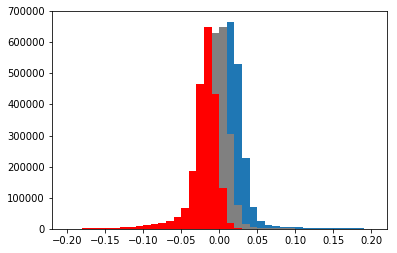

In [4]:
np.shape(evals_dm_1)
print('Min/Max of e1: {0:5.3f}, {1:5.3f}'.format(np.min(evals_dm_1[:,:,:,0]), np.max(evals_dm_1[:,:,:,0])))
print('Min/Max of e2: {0:5.3f}, {1:5.3f}'.format(np.min(evals_dm_1[:,:,:,1]), np.max(evals_dm_1[:,:,:,1])))
print('Min/Max of e3: {0:5.3f}, {1:5.3f}'.format(np.min(evals_dm_1[:,:,:,2]), np.max(evals_dm_1[:,:,:,2])))

eval1 = np.squeeze(evals_dm_1[:,:,:,0])
eval2 = np.squeeze(evals_dm_1[:,:,:,1])
eval3 = np.squeeze(evals_dm_1[:,:,:,2])

fig, ax = plt.subplots()

binw=0.01
ax = plt.hist(np.ravel(eval1), bins=np.arange(-0.2, 0.2+binw, binw), label='e1')
ax = plt.hist(np.ravel(eval2), bins=np.arange(-0.2, 0.2+binw, binw), label='e2', color='grey')
ax = plt.hist(np.ravel(eval3), bins=np.arange(-0.2, 0.2+binw, binw), label='e3', color='red')

plt.show()

---
Define a cosmic web array where the geometric cosmic web at each point is labeled as [0,1,2,3] respectively for voids, sheets, filaments, and nodes

In [5]:
eigenthres = 0.05

cw_arr = np.empty(np.shape(eval1))

get_node = np.where((eval1 > eigenthres) & (eval2> eigenthres) & (eval3 > eigenthres) )
get_fil = np.where((eval1 > eigenthres) & (eval2> eigenthres) & (eval3 < eigenthres) )
get_sheet = np.where((eval1 > eigenthres) & (eval2 < eigenthres) & (eval3 < eigenthres) )
get_void = np.where((eval1 < eigenthres) & (eval2 < eigenthres) & (eval3 < eigenthres) )

cw_arr[get_void] = 0.
cw_arr[get_sheet]= 1.
cw_arr[get_fil]  = 2.
cw_arr[get_node] = 3.

node_perc = np.count_nonzero(cw_arr[:, 48:77, 50:79] == 3.) /cw_arr[:, 48:77, 50:79].size*100.
fil_perc =  np.count_nonzero(cw_arr[:, 48:77, 50:79] == 2.)/cw_arr[:, 48:77, 50:79].size*100.
sheet_perc = np.count_nonzero(cw_arr[:, 48:77, 50:79] == 1.) /cw_arr[:, 48:77, 50:79].size*100.
void_perc = np.count_nonzero(cw_arr[:, 48:77, 50:79] == 0.) /cw_arr[:, 48:77, 50:79].size*100.

print('Volume filling fractions:')
print('[{0:4.1f}%,{1:4.1f}%, {2:4.1f}%, {3:4.1f}%] in [Nodes, Filaments, Sheets, Voids]'.format(node_perc,fil_perc,sheet_perc, void_perc))

Volume filling fractions:
[ 1.0%,12.3%, 39.1%, 47.6%] in [Nodes, Filaments, Sheets, Voids]


---
Implement 3D visualization with mayavi. To rotate and pan the visualization within the window, initialize mlab with 'x3d'. Note that the axes and other text doesn't show up in the x3d.

In [6]:
from mayavi import mlab
mlab.init_notebook('png')
#mlab.init_notebook('x3d')

# Fixed camera viewpoint
az = 235.
ele = 70.
dist = 400.
foc = (3900., 12., -8.5)



Notebook initialized with png backend.


In [7]:

den_sm_clipped = den_sm[:, 48:77, 50:79]
# transpose the array so that RA appears horizontal
np.transpose(den_sm_clipped, (0,2,1))
np.flip(den_sm_clipped, axis=0)

#print(np.shape(den_sm_clipped))
mlab.init_notebook('x3d')

z,y,x = np.mgrid[3775:4075:128j, -32.8:35.2:29j, -37.5:30.5:29j]

mlab.figure(figure=None, bgcolor=(0.,0.,0.), fgcolor=(1.,1.,1.),size=(570,350))
mlab.clf()

cont3d = mlab.contour3d(z,y,x, den_sm_clipped, contours=[0.2])


#mlab.text3d(50, 62, 85, 'COSMOS Density Field', scale=2,orientation=(270,0,0), orient_to_camera=False)
#mlab.orientation_axes( xlabel='Redshift', ylabel='Dec', zlabel='RA')

# Draw outline box
mlab.outline(cont3d, color=(1,1,1), line_width=1)

# Draw axes
ax=mlab.axes(cont3d, color=(1,1,1),xlabel='z (Mpc/h)', zlabel='Dec (Mpc/h)', ylabel='R.A. (Mpc/h)', nb_labels=10)
ax.axes.label_format='%.2f'
ax.axes.font_factor=1.
ax.axes.axis_title_text_property.font_size=2

mlab.view(azimuth=az, elevation=ele, distance=dist, focalpoint=foc)

cont3d



Notebook initialized with x3d backend.


Notebook initialized with png backend.



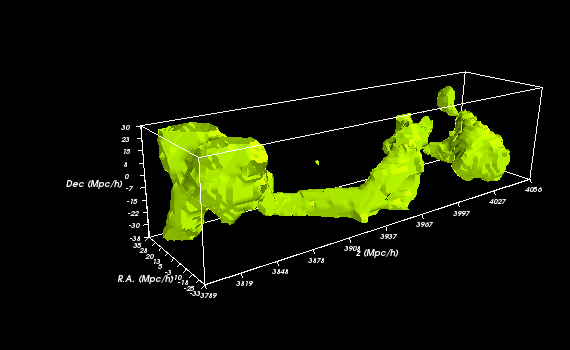

In [8]:
cw_clipped = cw_arr[:, 48:77, 50:79]
np.transpose(cw_clipped, (0,2,1))
np.flip(cw_clipped,axis=0)

mlab.init_notebook('png')

mlab.figure(figure=None, bgcolor=(0.,0.,0.), fgcolor=(1.,1.,1.),size=(570,350))
mlab.clf()

cont3d = mlab.contour3d(z,y,x, cw_clipped, contours=[1.9])


# Draw outline box
mlab.outline(cont3d, color=(1,1,1), line_width=1)

# Draw axes
ax=mlab.axes(cont3d, color=(1,1,1),xlabel='z (Mpc/h)', zlabel='Dec (Mpc/h)', ylabel='R.A. (Mpc/h)', nb_labels=10)
ax.axes.label_format='%.0f'
ax.axes.font_factor=1.
ax.axes.axis_title_text_property.font_size=2

foc_tmp = (3870., 12., -8.5)
mlab.view(azimuth=az, elevation=ele, distance=dist, focalpoint=foc_tmp)

cont3d

--- 
Next, we fill the sheets of the distribution with 3D balls to avoid ambiguity of the direction of the surface

Notebook initialized with png backend.



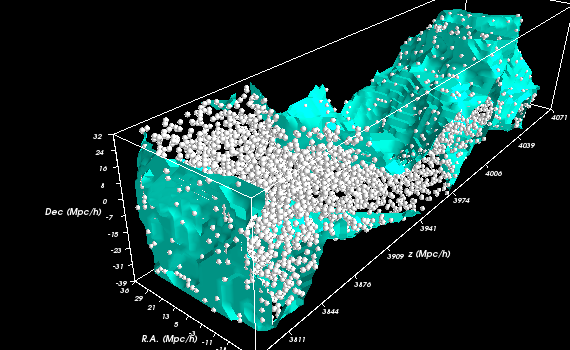

In [9]:
cw_clipped = cw_arr[:, 48:77, 50:79]
np.transpose(cw_clipped, (0,2,1))

sheet_points= np.where( (cw_clipped > 0.9))

mlab.init_notebook('png')

mlab.figure(figure=None, bgcolor=(0.,0.,0.), fgcolor=(1.,1.,1.),size=(570,350))
mlab.clf()

z_sheet = z[sheet_points]
y_sheet = y[sheet_points]
x_sheet = x[sheet_points]

rand_pts = np.random.choice(z_sheet.size, size=round(0.1*z_sheet.size), replace=False)

sheet3d = mlab.points3d(z_sheet[rand_pts],y_sheet[rand_pts],x_sheet[rand_pts],scale_factor=2.5)
cont3d = mlab.contour3d(z,y,x, cw_clipped, contours=[0.9])


# Draw outline box
mlab.outline(sheet3d, color=(1,1,1), line_width=1)

# Draw axes
ax=mlab.axes(sheet3d, color=(1,1,1),xlabel='z (Mpc/h)', zlabel='Dec (Mpc/h)', ylabel='R.A. (Mpc/h)', nb_labels=10)
ax.axes.label_format='%.0f'
ax.axes.font_factor=1.
ax.axes.axis_title_text_property.font_size=2

# Fixed camera viewpoint
az = 220.
ele = 60.
dist = 300.
foc = (3850., 12., -8.5)
mlab.view(azimuth=az, elevation=ele, distance=dist, focalpoint=foc)

sheet3d

In [10]:
print(round(3.3))


3
